This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [2]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.callbacks import *
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K
from spatial_transformer import SpatialTransformer

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../datasets/mnist_cluttered_60x60_6distortions.npz"
# DIM = 40
# dep = 1
# mnist_cluttered = '../datasets/mnist_sequence1_sample_5distortions5x5.npz'

DIM = 60
dep = 3
nb_classes = 13
mnist_cluttered = '../datasets/train.npz'

Using TensorFlow backend.


In [3]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], data['y_train']
X_valid, y_valid = data['x_valid'], data['y_valid']
X_test, y_test = data['x_test'], data['y_test']
# X_train, y_train = data['X_train'], np.argmax(data['y_train'], axis=-1)
# X_valid, y_valid = data['X_valid'], np.argmax(data['y_valid'], axis=-1)
# X_test, y_test = data['X_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, dep))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, dep))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, dep))
print y_valid.shape
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
print y_valid.shape
print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))


input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (DIM, DIM, dep)
print("Input shape:",input_shape)

(1075, 1)
(1075, 13)
Train samples: (9680, 60, 60, 3)
Validation samples: (1075, 60, 60, 3)
Test samples: (13486, 60, 60, 3)
('Input shape:', (60, 60, 3))


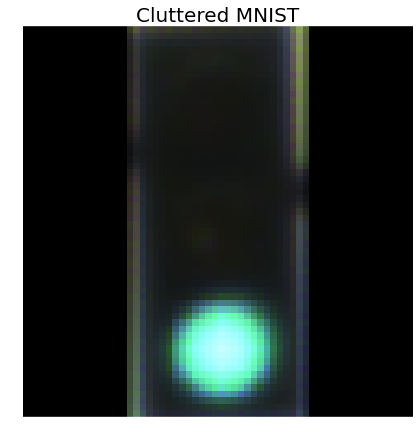

In [4]:
plt.figure(figsize=(7,7))
if dep ==3:
    plt.imshow(X_train[101].reshape(DIM, DIM, dep), interpolation='none')
else:  
    plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [5]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [6]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, (5, 5)))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights ,name='trans_mat'))
#locnet.add(Activation('sigmoid'))

In [7]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             output_size=(DIM/2,DIM/2), input_shape=input_shape))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
trans_lay = model.layers[0]
for lay in model.layers:
    print lay.name
print trans_lay
lay = trans_lay

# for w in model.trainable_weights:
#     if w.name == 'trans_mat/kernel:0':
#         k = w
#     elif w.name == 'trans_mat/bias:0':
#         b = w
# print dir(b)
# b._variable
def show_trans_lay(lay):
    k = lay.get_weights()[6]
    b = lay.get_weights()[7]
    print k
    print b
# show_trans_lay(trans_lay)


spatial_transformer_1
conv2d_3
activation_2
max_pooling2d_3
conv2d_4
activation_3
max_pooling2d_4
flatten_2
dense_2
activation_4
dense_3
activation_5


In [8]:
XX = model.input
model.load_weights('./model.h5')
YY = model.layers[0].output
F = K.function([XX], [YY])
labels = ['GreenStraightRight', 'off', 'GreenStraightLeft', 'GreenStraight', 'RedStraightLeft', 'GreenRight', 'Yellow', 'RedStraight', 'Green', 'GreenLeft', 'RedRight', 'RedLeft', 'Red']
#summary
def setup_summary(labels):
    summary_vars = [tf.Variable(0.) for i in range(len(labels) *5 +1 )] 
    summary_placeholders = [tf.Variable(0.) for var in summary_vars ]
    
    tf.summary.scalar('Total_Accuracy/Epoch', summary_vars[0])
        
    for i,label in enumerate(labels): 
        idx = 5*i + 1
        tf.summary.scalar('%s_%s/Epoch' % (label, 'Accuracy'), summary_vars[idx])
        tf.summary.scalar('%s_%s/Epoch' % (label, 'True_Positive_Rate'), summary_vars[idx+1])
        tf.summary.scalar('%s_%s/Epoch' % (label, 'True_Positive'), summary_vars[idx+2])
        tf.summary.scalar('%s_%s/Epoch' % (label, 'False_Positive'), summary_vars[idx+3])
        tf.summary.scalar('%s_%s/Epoch' % (label, 'False_Negative'), summary_vars[idx+4])
    
    
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in
                  range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op
sess = tf.InteractiveSession()
K.set_session(sess)



summary_placeholders, update_ops, summary_op = \
            setup_summary(labels)
summary_writer = tf.summary.FileWriter(
            './summary'  , sess.graph)
sess.run(tf.global_variables_initializer())
        
        



In [9]:
print(X_train.shape[0]/batch_size)

def class_acc(model,x, y_true, labels, epoch):
    y_pred = np.argmax(model.predict(x), axis=-1)
    y_true = np.argmax(y_true, axis=-1)
    num = y_true.shape[0]
    #count labels
    count = [0] * len(labels)
    #True Positive
    tp = [0.] * len(labels)
    #True Negative
    tn = [0.] * len(labels)
    #False Positive
    fp = [0.] * len(labels)
    #False Negative
    fn = [0.] * len(labels)
    total_acc = 0.
    
    for i in range(num):
        y_p,y_t, = y_pred[i], y_true[i]
        count[y_t] += 1
        if y_p == y_t:
            total_acc += 1
            tp[y_t] += 1
            for i in range(len(labels)):
                if i != y_t:
                    fn[i] += 1
        else:
            tn[y_t] += 1
            fp[y_p] += 1     
    
    total_acc = total_acc / num
    #
    acc = [0.] * len(labels)
    tpr = [0.] * len(labels)
    tnr = [0.] * len(labels)
    fpr = [0.] * len(labels)
    fnr = [0.] * len(labels)
    for i in range(len(labels)):
        acc[i] = float(tp[i]+tn[i]) / (tp[i]+ tn[i]+ fp[i]+ fn[i])
        tpr[i] = float(tp[i]) / (tp[i] + fn[i]) if (tp[i] + fn[i]) != 0 else 0
        tnr[i] = float(tn[i]) / (tn[i] + fp[i]) if (tn[i] + fp[i]) != 0 else 0
        fpr[i] = 1. - tnr[i] 
        fnr[i] = 1. - tpr[i] 
        
    result = [total_acc]
    
    result.extend(acc)
    result.extend(tpr)
    result.extend(tnr)
    result.extend(fpr)
    result.extend(fnr)
    
    
    #summary
    for i,result in enumerate(result):
        sess.run(update_ops[i], feed_dict={
            summary_placeholders[i]: result
        })
    summary_str = sess.run(summary_op)
    summary_writer.add_summary(summary_str, epoch)
    
tb_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: class_acc(model, X_test, y_test, labels, epoch)
)


    
    
    
    

75


In [ ]:
def ceil(x):
    a = int(x)
    return a+1 if x > a else a
nb_epochs = 100 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()

def show_trans_lay(lay):
    idx  = [0,2,4,5]
    idx = range(6)
    k = lay.get_weights()[6]
    b = lay.get_weights()[7]
    print k[:,idx]
    print b[idx]
def reset_trans_lay(lay):
    ws = lay.get_weights()
    k = ws[6]
    b = ws[7]
    k[:,1] = 0
    k[:,3] = 0
    b[1] = 0
    b[3] = 0
    lay.set_weights(ws)
    
    
trans_lay = model.layers[0]

reset_callback = LambdaCallback(
    on_batch_end=lambda batch, logs: reset_trans_lay(trans_lay)
)

def equal_class_weight(y_train, nb_classes):
    num = y_train.shape[0]
    count = np.zeros([nb_classes,])
    y_train = np.argmax(y_train, axis=-1).astype(np.uint8)
    
    for i in range(num):
        y = int(y_train[i])
        count[y] += 1
    w = count / num
    return w
    

try:
    
    for e in range(nb_epochs): 
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
#         for b in range( ceil(float(X_train.shape[0]) / batch_size) ):
#             print('%7d / %7d' % (f, X_train.shape[0]))

#             f = b * batch_size
#             l = min(X_train.shape[0]+1, (b+1) * batch_size)
#             X_batch = X_train[f:l]
#             y_batch = y_train[f:l]
            
            
#             loss = model.train_on_batch(X_batch, y_batch)
#             reset_trans_lay(trans_lay)
        
            
#             #print(loss)
#             #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
#         scorev = model.evaluate(X_valid, y_valid, verbose=1)
#         scoret = model.evaluate(X_test, y_test, verbose=1)
        model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_test, y_test),
                  callbacks=[reset_callback, tb_callback],
                 class_weight = equal_class_weight(y_test, nb_classes))
    #         print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            Xresult = F([X_train[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                if dep ==3:
                    plt.imshow(image)
                else:  
                    plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
#             show_trans_lay(trans_lay)
            plt.show()
            
except KeyboardInterrupt:
    pass
print 'Done'
# show_trans_lay(trans_lay)

----------------------------------------
Train on 9680 samples, validate on 13486 samples
Epoch 1/100
9680/9680 [==============================] - 56s - loss: 1.4410 - acc: 0.6096 - val_loss: 0.4143 - val_acc: 0.9197
Epoch 2/100
6912/9680 [====================>.........] - ETA: 7s - loss: 1.0542 - acc: 0.6898

### Visualizing what the Spatial Transformer learned

In [17]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

# xx = Xaug.reshape([-1,60,60])
# xx = Xaug[0,:,:]
    
# for i in range(xx.shape[0]):
#     print xx[i,:]
 


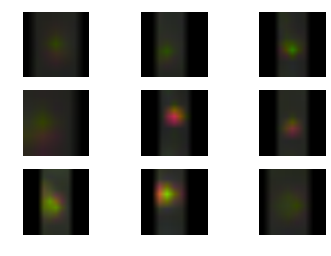

In [18]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

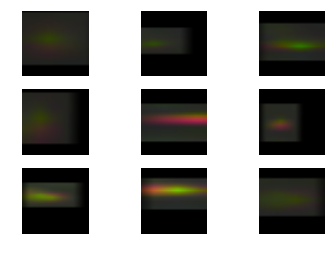

In [19]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

In [36]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
data = np.load('../datasets/train.npz')
X_train, y_train = data['x_train'], data['y_train']
X_valid, y_valid = data['x_valid'], data['y_valid']
X_test, y_test = data['x_test'], data['y_test']
x = X_train[0,:,:,:]
y = y_train
print y.shape
# for i in range(60):
#     print x[i,:,:]



(9680, 1)


 0 GreenStraightRight 3 0
1 off 659 442
2 GreenStraightLeft 1 0
3 GreenStraight 16 0
4 RedStraightLeft 1 0
5 GreenRight 12 0
6 Yellow 400 154
7 RedStraight 9 0
8 Green 4686 7569
9 GreenLeft 157 0
10 RedRight 5 0
11 RedLeft 988 0
12 Red 2743 5321


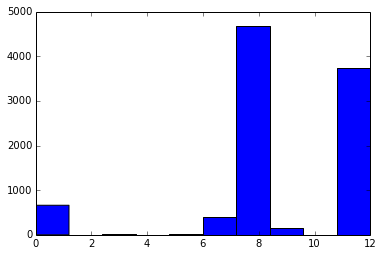

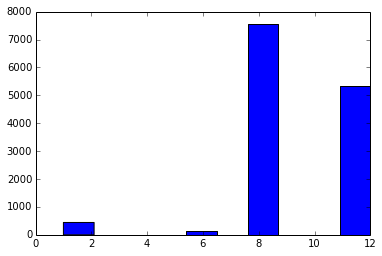

In [28]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt



batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
dep = 3
nb_classes = 13
data = np.load('../datasets/train.npz')
y_train = data['y_train']
y_test = data['y_test']
labels = ['GreenStraightRight', 'off', 'GreenStraightLeft', 'GreenStraight', 'RedStraightLeft', 'GreenRight', 'Yellow', 'RedStraight', 'Green', 'GreenLeft', 'RedRight', 'RedLeft', 'Red']
ay = [0]*nb_classes
ay2 = [0]*nb_classes
for y in y_train:
    ay[int(y)] += 1
for y in y_test:
    ay2[int(y)] += 1
for i,l in enumerate(labels):
    print i,l,ay[i],ay2[i]    
    
x = range(13)
plt.hist(y_train)
plt.show()

plt.hist(y_test)
plt.show()


